In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import pickle
import re
import datetime
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('chatgpt.csv')

In [3]:
df.head()

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2024-09-06,Claim who accept.,Every quite sense including six lot have never...,4,morrowthomas,30,22,Flipkart,ar,Nepal,3.8.4,No
1,3/7/2025,Growth pretty wish.,Ask develop bag also his worker pass. Expert w...,4,sheakimberly,120,22,Flipkart,ar,Guinea,5.2.6,Yes
2,########,What then spend offer reason whom none.,If customer address region try near risk next ...,5,katherineali,130,21,Flipkart,es,Kuwait,3.6.5,No
3,########,Say dog drug enter director strong student.,To television loss election him small detail r...,1,eric11,72,26,Amazon,pt,Uruguay,5.7.2,No
4,########,Purpose here beyond.,Pass share must amount lot per manage world to...,5,chloe42,123,27,Amazon,zh,Mayotte,5.8.6,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               250 non-null    object
 1   title              250 non-null    object
 2   review             250 non-null    object
 3   rating             250 non-null    int64 
 4   username           250 non-null    object
 5   helpful_votes      250 non-null    int64 
 6   review_length      250 non-null    int64 
 7   platform           250 non-null    object
 8   language           250 non-null    object
 9   location           250 non-null    object
 10  version            250 non-null    object
 11  verified_purchase  250 non-null    object
dtypes: int64(3), object(9)
memory usage: 23.6+ KB


In [5]:
print(df.shape)

(250, 12)


In [6]:
df.describe()

,rating,helpful_votes,review_length
count,250.000000,250.000000,250.000000
mean,2.980000,94.416000,20.852000
std,1.465671,57.020842,3.459185
min,1.000000,0.000000,13.000000
25%,2.000000,42.250000,18.000000
50%,3.000000,95.000000,21.000000
75%,4.000000,140.500000,23.000000
max,5.000000,200.000000,29.000000


In [7]:
print('Duplicate Values',df.duplicated().sum())
print('Null Values :', df.isnull().sum())

Duplicate Values 0
Null Values : date                 0
title                0
review               0
rating               0
username             0
helpful_votes        0
review_length        0
platform             0
language             0
location             0
version              0
verified_purchase    0
dtype: int64


In [8]:
print(df['date'])

0      2024-09-06
1        3/7/2025
2        ########
3        ########
4        ########
          ...    
245      ########
246      ########
247      ########
248      3/7/2024
249      ########
Name: date, Length: 250, dtype: object


In [9]:
df = df.drop(columns=['date'])

In [10]:
df['rating'].value_counts()

rating
1    59
3    57
5    55
4    41
2    38
Name: count, dtype: int64

In [11]:
df['version'].value_counts()

version
5.9.6    3
1.4.7    3
4.7.3    3
3.0.6    3
2.1.7    3
        ..
2.3.8    1
1.9.3    1
2.3.4    1
3.9.6    1
3.1.3    1
Name: count, Length: 197, dtype: int64

In [12]:
# Get numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical Columns:")
print(numerical_cols)

# Get string (object) columns
string_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()
print("\nString Columns:")
print(string_cols)

Numerical Columns:
['rating', 'helpful_votes', 'review_length']

String Columns:
['title', 'review', 'username', 'platform', 'language', 'location', 'version', 'verified_purchase']


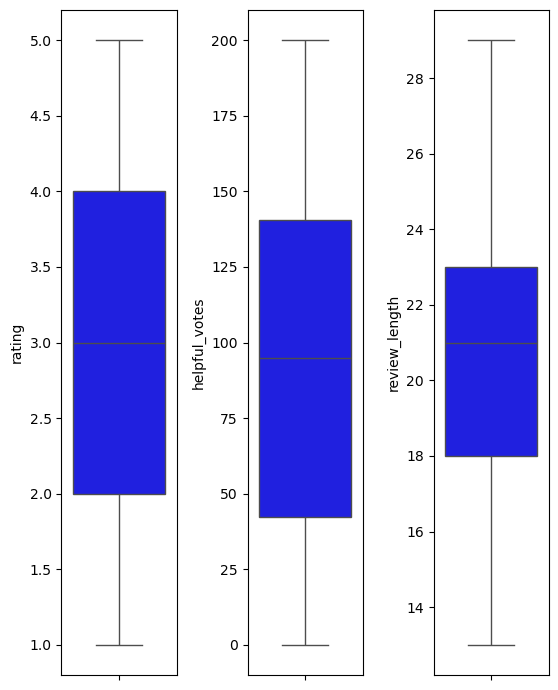

In [13]:
from scipy.stats import skew
features = ['rating', 'helpful_votes','review_length']
plt.figure(figsize=(15, 7))
for i in range(0, len(features)):
    plt.subplot(1, 8, i+1)
    sns.boxplot(y=df[features[i]],color='blue',)
    plt.tight_layout()

In [14]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation/numbers
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Remove stopwords and lemmatize each word
    return ' '.join(words)

# Then apply the function
df['clean_review'] = df['review'].apply(clean_text)

In [17]:
def label_sentiment(rating):
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['sentiment'] = df['rating'].apply(label_sentiment)

In [18]:
df.drop('review', axis=1, inplace=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15476\1319090466.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette = "viridis")


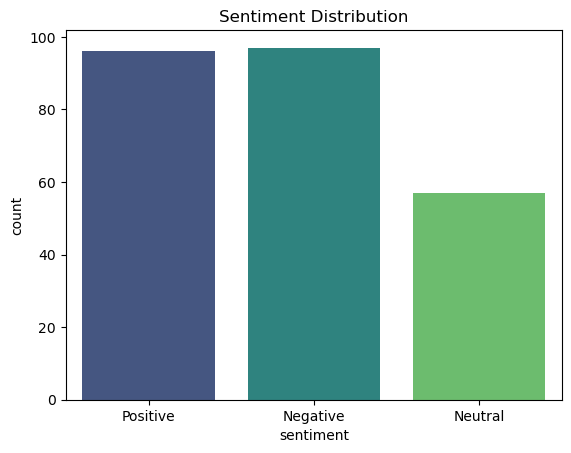

In [19]:
sns.countplot(x='sentiment', data=df, palette = "viridis")
plt.title('Sentiment Distribution')
plt.show()

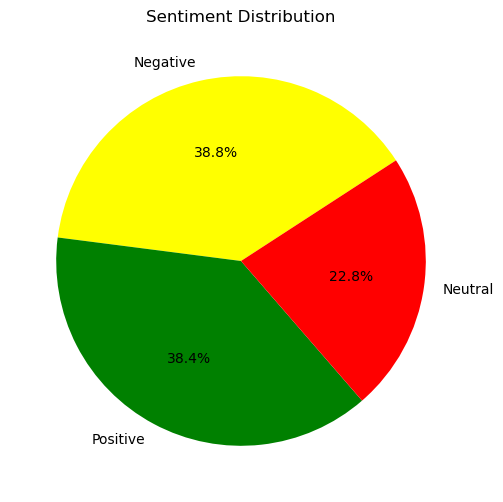

In [20]:
plt.figure(figsize=(6, 6))
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', startangle=33, colors=['yellow', 'green', 'red'])
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()

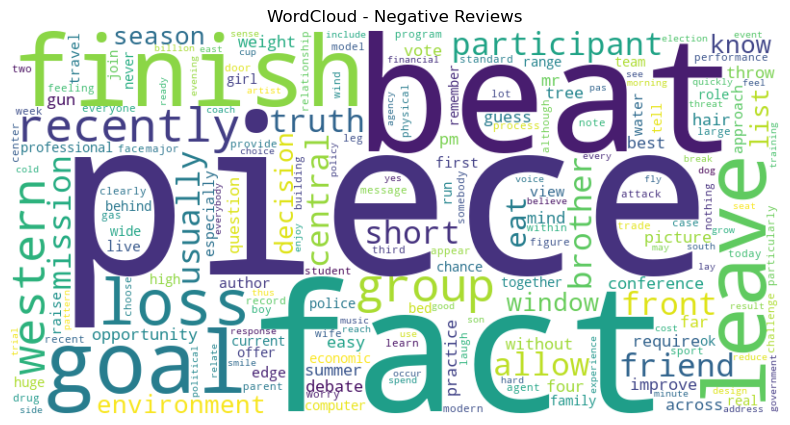

In [21]:
negative_text = ' '.join(df[df['sentiment'] == 'Negative']['clean_review'])

wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Negative Reviews')
plt.show()

In [24]:
df['sentiment'].value_counts()

sentiment
Negative    97
Positive    96
Neutral     57
Name: count, dtype: int64

In [25]:
def label_sentiment(rating):
    if rating in [1, 2]:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['sentiment'] = df['rating'].apply(label_sentiment)

In [57]:
df

,title,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase,clean_review,sentiment
0,46,4,154,30,22,2,0,98,3.8.4,0,84,2
1,99,4,207,120,22,2,0,60,5.2.6,1,18,2
2,245,5,109,130,21,2,3,77,3.6.5,0,56,2
3,195,1,64,72,26,0,7,150,5.7.2,0,223,0
4,175,5,37,123,27,0,9,88,5.8.6,0,167,2
...,...,...,...,...,...,...,...,...,...,...,...,...
245,82,5,8,109,22,1,2,90,2.3.4,1,109,2
246,186,5,216,26,23,4,4,9,3.5.3,0,54,2
247,94,1,150,67,24,1,8,120,3.9.6,0,162,0
248,180,5,231,29,19,0,9,68,4.9.2,0,160,2


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15476\2200193819.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment'], palette='pastel')


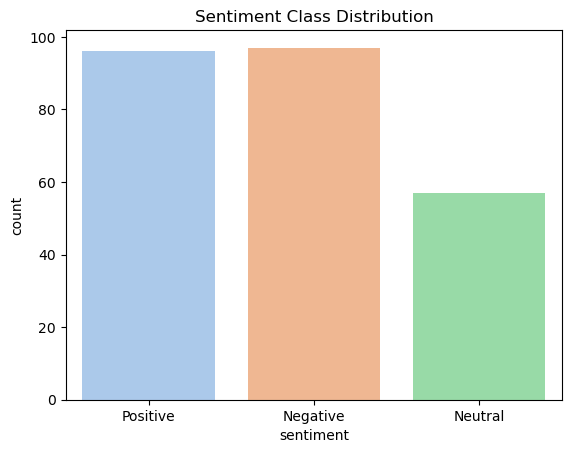

In [22]:
sns.countplot(x=df['sentiment'], palette='pastel')
plt.title("Sentiment Class Distribution")
plt.show()

In [23]:
# Separate classes
df_negative = df[df.sentiment == 'Negative']
df_neutral = df[df.sentiment == 'Neutral']
df_positive = df[df.sentiment == 'Positive']

# Downsample majority classes to match Neutral
df_negative_down = resample(df_negative, replace=False, n_samples=len(df_neutral), random_state=42)
df_positive_down = resample(df_positive, replace=False, n_samples=len(df_neutral), random_state=42)

# Combine balanced dataset
df_balanced = pd.concat([df_negative_down, df_neutral, df_positive_down])

In [24]:
print(df_balanced['sentiment'].value_counts())

sentiment
Negative    57
Neutral     57
Positive    57
Name: count, dtype: int64


In [25]:
print(df['username'].apply(type).unique())

[<class 'str'>]


In [26]:
df['username'] = df['username'].apply(
    lambda x: str(x) if isinstance(x, datetime.datetime) else x
)

In [27]:
df

,title,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase,clean_review,sentiment
0,Claim who accept.,4,morrowthomas,30,22,Flipkart,ar,Nepal,3.8.4,No,every quite sense including six lot never effe...,Positive
1,Growth pretty wish.,4,sheakimberly,120,22,Flipkart,ar,Guinea,5.2.6,Yes,ask develop bag also worker pas expert white a...,Positive
2,What then spend offer reason whom none.,5,katherineali,130,21,Flipkart,es,Kuwait,3.6.5,No,customer address region try near risk next gir...,Positive
3,Say dog drug enter director strong student.,1,eric11,72,26,Amazon,pt,Uruguay,5.7.2,No,television loss election small detail red son ...,Negative
4,Purpose here beyond.,5,chloe42,123,27,Amazon,zh,Mayotte,5.8.6,No,pas share must amount lot per manage world mak...,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...
245,Father who tax.,5,amassey,109,22,App Store,en,Micronesia,2.3.4,Yes,government card history suddenly save theory s...,Positive
246,Remain movement bit step direction give reduce.,5,stevenandrews,26,23,Website,fr,Austria,3.5.3,No,court control million hundred offer total hit ...,Positive
247,Form now then watch certain.,1,michelle90,67,24,App Store,ru,Rwanda,3.9.6,No,opportunity ask yet large practice time live r...,Negative
248,Recent catch gas benefit great religious.,5,victor24,29,19,Amazon,zh,Iran,4.9.2,No,onto simple audience including claim create wo...,Positive


In [28]:
df.to_csv(r"C:\Users\ADMIN\Desktop\AI ECHO\cleaned chatgpt.csv", index=False)
print("Cleaned CSV saved successfully at: C:\\Users\\ADMIN\\Desktop\\AI ECHO\\cleaned chatgpt.csv")

Cleaned CSV saved successfully at: C:\Users\ADMIN\Desktop\AI ECHO\cleaned chatgpt.csv


In [29]:
# List of categorical columns
categorical_cols = ['platform', 'language', 'location', 'verified_purchase',
                     'title', 'clean_review','sentiment','username']	

# Initialize LabelEncoder
le = LabelEncoder()

# Apply encoding
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

_***EDA***_

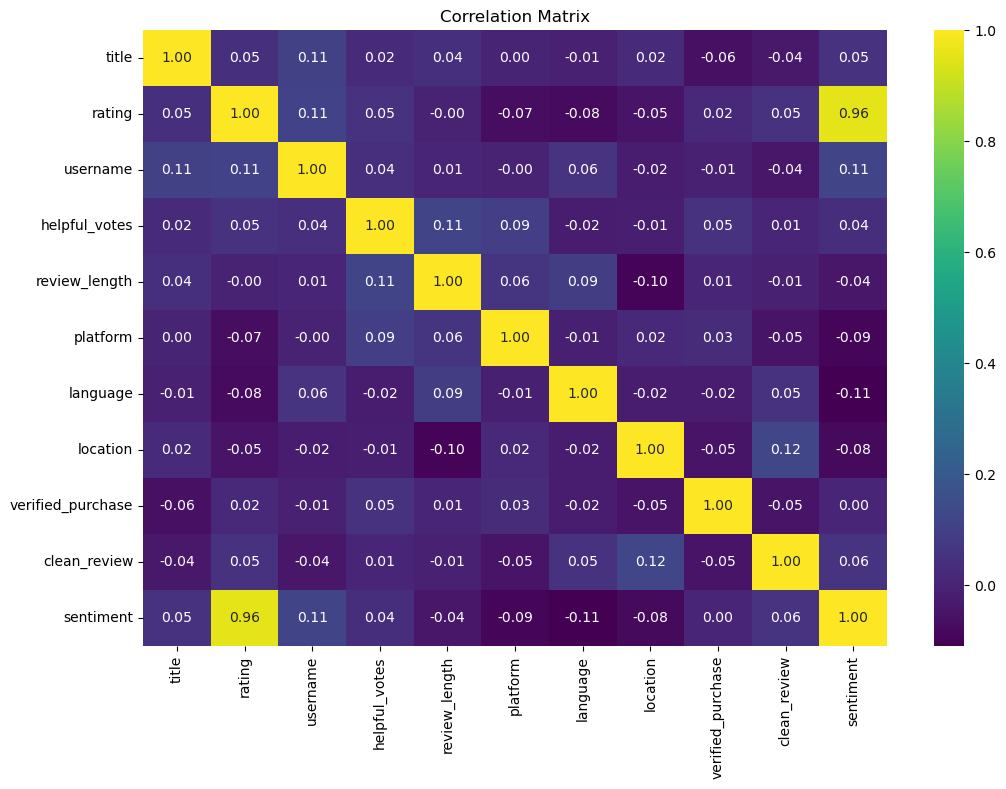

In [30]:
# Step 1: Generate the correlation matrix (only for numeric columns)
correlation_matrix = df.corr(numeric_only=True)

# Step 2: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15476\1346561287.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df,palette='colorblind')


Text(0.5, 1.0, 'Rating Distribution')

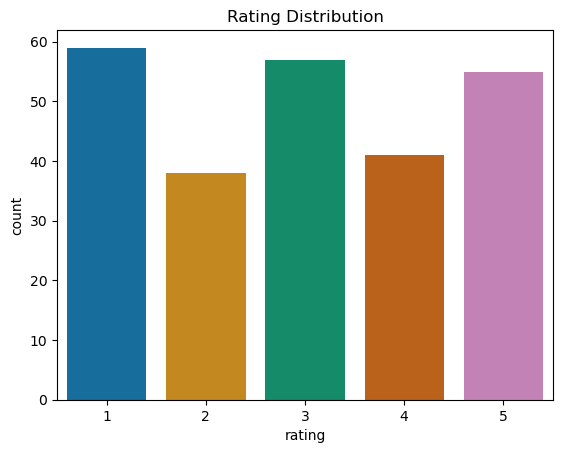

In [31]:
sns.countplot(x='rating', data=df,palette='colorblind')
plt.title('Rating Distribution')

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15476\1857097740.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x='rating', y='review_length',palette="muted")


Text(0.5, 1.0, 'Review Length by Rating')

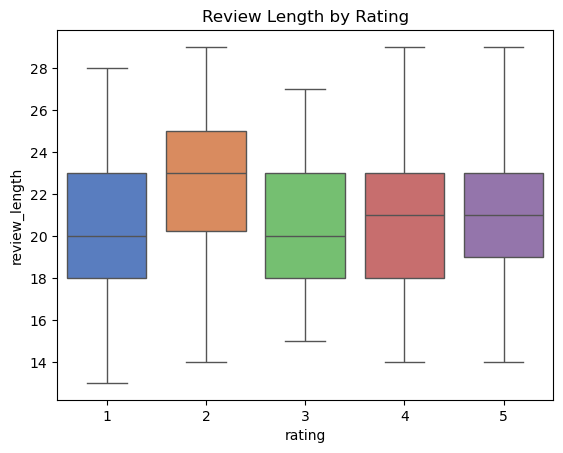

In [32]:
sns.boxplot(data=df,x='rating', y='review_length',palette="muted")
plt.title('Review Length by Rating')

Text(0.5, 1.0, 'Top 10 Locations by Review Count')

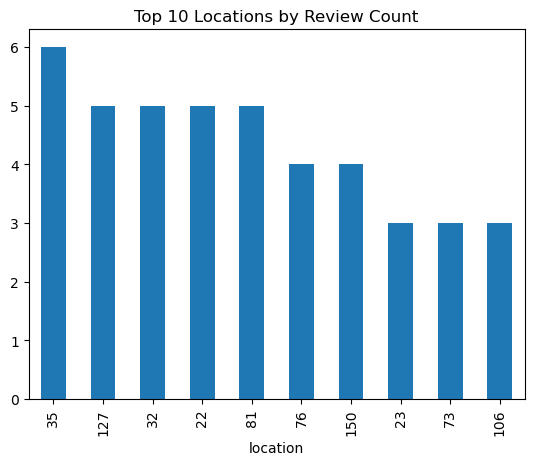

In [33]:
df['location'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Locations by Review Count')

Text(0.5, 1.0, 'Verified Purchase Distribution')

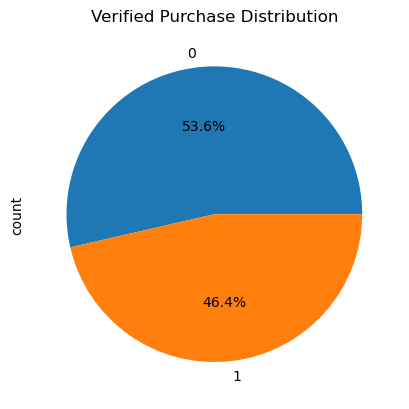

In [34]:
df['verified_purchase'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Verified Purchase Distribution')

Text(0.5, 1.0, 'Top 10 Active Users')

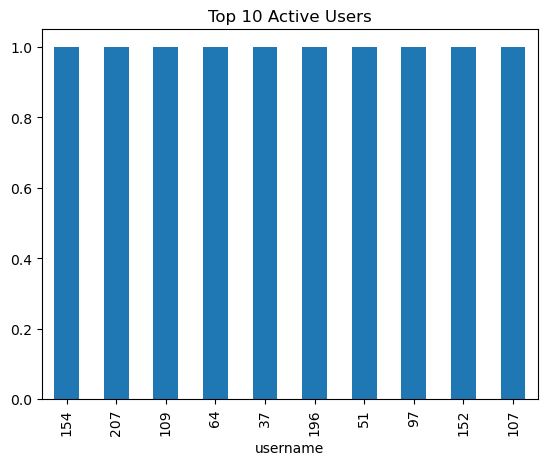

In [35]:
df['username'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Active Users')

Text(0.5, 1.0, 'Top Languages in Reviews')

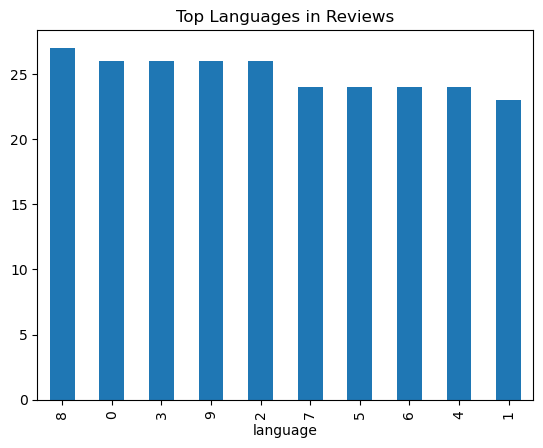

In [36]:
df['language'].value_counts().head(10).plot(kind='bar')
plt.title('Top Languages in Reviews')

Text(0.5, 1.0, 'Helpful Votes Across Ratings')

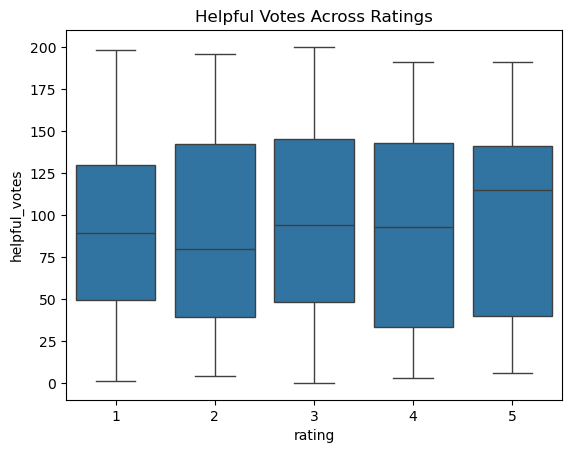

In [37]:
sns.boxplot(x='rating', y='helpful_votes', data=df)
plt.title('Helpful Votes Across Ratings')

In [38]:
# Assuming 'df' is your DataFrame and you want to drop columns for features
X = df.drop(['sentiment', 'helpful_votes', 'review_length', 'version'], axis=1)
y = df['sentiment']

In [39]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

In [41]:
# Vectorize the text
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)


# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        18

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



<Axes: >

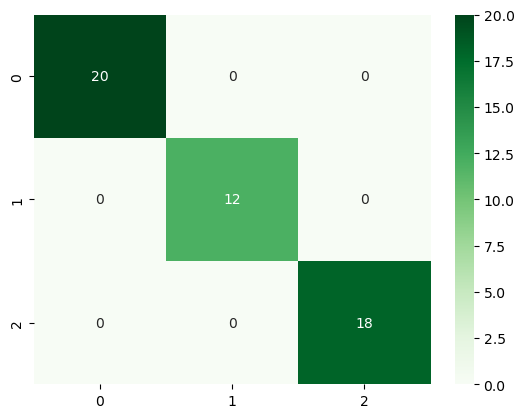

In [42]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')

In [43]:
print(f"Accuracy is {round(accuracy_score(y_test, model.predict(X_test))*100, 2)}%")

Accuracy is 100.0%


In [44]:
df.iloc[0]

title                   46
rating                   4
username               154
helpful_votes           30
review_length           22
platform                 2
language                 0
location                98
version              3.8.4
verified_purchase        0
clean_review            84
sentiment                2
Name: 0, dtype: object

In [45]:
X_train.columns

Index(['title', 'rating', 'username', 'platform', 'language', 'location',
       'verified_purchase', 'clean_review'],
      dtype='object')

In [46]:
# Your original feature names
feature_names = X.columns.tolist()  # Ensure this matches your training features

# Sample input
input_data = pd.DataFrame([[46, 4, 154, 2, 0, 98, 0, 84]], columns=feature_names)

# Direct prediction (no scaling required)
prediction = model.predict(input_data)

# Interpret prediction
if prediction[0] == 0:
    print("✅ The model predicts: **Negative Sentiment**")
elif prediction[0] == 2:
    print("⚠️ The model predicts: **Neutral Sentiment**")
else:
    print("🚀 The model predicts: **Positive Sentiment**")

⚠️ The model predicts: **Neutral Sentiment**


In [47]:
pickle.dump(model, open("NLP_model.pkl", 'wb'))

In [48]:
# loading the saved model
loaded_model = pickle.load(open('NLP_model.pkl', 'rb'))

In [49]:
for column in X.columns:
  print(column)

title
rating
username
platform
language
location
verified_purchase
clean_review
